# Counting Rings in Cropped Images - Real Data


Mod of [Zach Muller's WWF 01_Custom.ipynb](https://walkwithfastai.com/Custom).

Here we'll take cropped images of antinodes and try to count the rings.

> NOTE: IceVision will supply bounding boxes for cropping never-before-seen images.  That seems to work ok.  Putting this all together into one workflow is... the next thing. ;-) 

In [ ]:
#all_slow

In [ ]:
#hide
#Run once per session
!pip install fastai espiownage -q --upgrade

And import our libraries

In [ ]:
from fastai.vision.all import *
from espiownage.core import *

Below you will find the exact imports for everything we use today

In [ ]:
from fastcore.foundation import L
from fastcore.xtras import Path # @patch'd properties to the Pathlib module

from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle, lr_find 
from fastai.data.external import untar_data, URLs

from fastai.data.block import RegressionBlock, DataBlock
from fastai.data.transforms import get_image_files, Normalize, RandomSplitter, parent_label

from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner # imports @patch'd properties to Learner including `save`, `load`, `freeze`, and `unfreeze`
from fastai.optimizer import ranger

from fastai.vision.augment import aug_transforms, RandomResizedCrop, Resize
from fastai.vision.core import imagenet_stats
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner
from fastai.vision.utils import download_images, verify_images

In [ ]:
path = Path('/home/shawley/datasets/espiownage-cleaner/crops') # real physics data is local and private

# cyclegan fake data is public, for demo & reproducibility:  add force_download=True to grab a new version if needed
#path = untar_data('http://hedges.belmont.edu/~shawley/espiownage-cyclegan.tgz') / 'crops'
print(path)

/home/shawley/datasets/espiownage-cleaner/crops


In [ ]:
fnames = get_image_files(path)
print(f"{len(fnames)} total cropped images")
ind = 1  # pick one cropped image
fnames[ind]

4962 total cropped images


Path('/home/shawley/datasets/espiownage-cleaner/crops/06241902_proc_01083_156_232_247_339_1.8.png')

For labels, we want the ring count which is the number between the last '_' and the '.png'

In [ ]:
def label_func(x):  
    return round(float(x.stem.split('_')[-1]),2)

print(label_func(fnames[ind]))

1.8


In [ ]:
cropsize = (300,300) # pixels
croppedrings = DataBlock(blocks=(ImageBlock, RegressionBlock(n_out=1)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=label_func,
                   item_tfms=Resize(cropsize, ResizeMethod.Squish),
                   batch_tfms=[*aug_transforms(size=cropsize), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = croppedrings.dataloaders(path, bs=32)

/home/shawley/envs/espi/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


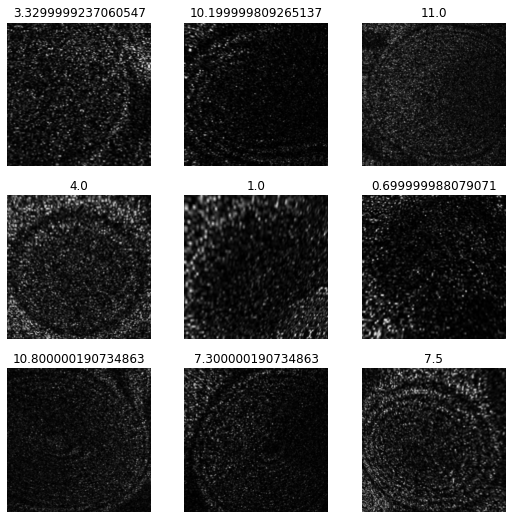

In [ ]:
dls.show_batch(max_n=9)

## Train model

We'll define something like accuracy:

In [ ]:
def acc_reg(inp, targ, bin_size=1):  # are they within +/- bin_size of each other?
    where_correct = (inp-targ).abs() < bin_size
    return where_correct.float().mean() 

def acc_reg05(inp, targ): return acc_reg(inp, targ, bin_size=0.5)
def acc_reg1(inp, targ): return acc_reg(inp, targ, bin_size=1)
def acc_reg15(inp, targ): return acc_reg(inp, targ, bin_size=1.5)
def acc_reg2(inp, targ): return acc_reg(inp, targ, bin_size=2)

In [ ]:
opt = ranger

In [ ]:
#PETS example learner:learn = cnn_learner(dls, resnet34, pretrained=True, loss_func=MSELossFlat(), n_out=1, y_range=(0,11), opt_func=opt)#.to_fp16()

y_range=(0.5,11.5)  # try to stay in the semi-linear range of the sigmoid; our values are 1 to 11. 
learn = cnn_learner(dls, resnet34, n_out=1, y_range=y_range, metrics=[mae, acc_reg05,acc_reg1,acc_reg15,acc_reg2], loss_func=MSELossFlat(), opt_func=opt)

/home/shawley/envs/espi/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


/home/shawley/envs/espi/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0063095735386013985)

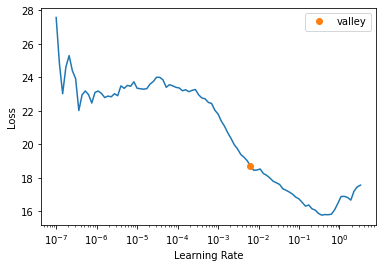

In [ ]:
learn.lr_find()

In [ ]:
#learn.fine_tune(10, 1e-2)
learn.fine_tune(20, 6e-3, freeze_epochs=2)

epoch,train_loss,valid_loss,mae,acc_reg05,acc_reg1,acc_reg15,acc_reg2,time
0,9.532753,6.264864,1.818764,0.135333,0.211410,0.291583,0.338521,00:20
1,7.144313,5.535294,1.691392,0.131048,0.208008,0.293567,0.340946,00:20


epoch,train_loss,valid_loss,mae,acc_reg05,acc_reg1,acc_reg15,acc_reg2,time
0,5.225143,3.399022,1.260723,0.142295,0.231729,0.313256,0.366620,00:26
1,4.182885,3.052487,1.169587,0.138703,0.230595,0.310389,0.362053,00:26
2,3.606144,2.776766,1.110855,0.131363,0.228894,0.310421,0.368479,00:26
3,3.069281,2.993369,1.189970,0.128938,0.239541,0.320565,0.379914,00:26
4,2.695820,1.717144,0.900067,0.145665,0.253654,0.325636,0.386719,00:27
5,2.664281,1.689848,0.904840,0.131930,0.253654,0.340820,0.402627,00:26
6,2.358885,2.988462,1.260464,0.111612,0.220136,0.315115,0.383065,00:27
7,2.380904,2.359108,0.956433,0.143208,0.247763,0.322675,0.377709,00:27
8,2.295314,2.239640,0.965556,0.132907,0.242314,0.320943,0.379599,00:27
9,2.218803,1.841830,1.000267,0.119015,0.234690,0.328881,0.399855,00:27


In [ ]:
learn.save('crop-rings-real')

Path('models/crop-rings-real.pth')

## Interpretation

In [ ]:
learn.load('crop-rings-real');

In [ ]:
preds, targs, losses = learn.get_preds(with_loss=True) # validation set only
len(preds)

992

I'll define a method to show a single prediction

In [ ]:
def showpred(ind, preds, targs, losses, dls): # show prediction at this index
    print(f"preds[{ind}] = {preds[ind]}, targs[{ind}] = {targs[ind]}, loss = {losses[ind]}")
    print(f"file = {dls.valid.items[ind]}")
    print("Image:")
    dls.valid.dataset[ind][0].show()

preds[0] = tensor([6.6423]), targs[0] = 10.670000076293945, loss = 16.22216796875
file = /home/shawley/datasets/espiownage-cleaner/crops/06241902_proc_00904_132_67_287_222_10.67.png
Image:


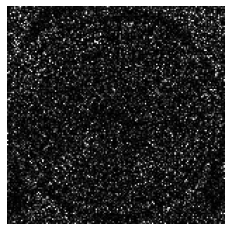

In [ ]:
showpred(0, preds, targs, losses, dls)

And now we'll run through predictions for the whole validation set:

In [ ]:
#preds, targs, losses = learn.get_preds(with_loss=True)
results = []
for i in range(len(preds)):
    line_list = [dls.valid.items[i].stem]+[round(targs[i].cpu().numpy().item(),2), round(preds[i][0].cpu().numpy().item(),2), losses[i].cpu().numpy(), i]
    results.append(line_list)

# store as pandas dataframe
res_df = pd.DataFrame(results, columns=['filename', 'target', 'prediction', 'loss','i'])

We can do our own version of printing top_losses:

In [ ]:
res_df = res_df.sort_values('loss', ascending=False)
res_df.head()

,filename,target,prediction,loss,i
228,06241902_proc_00522_0_34_91_246_1.0,1.00,10.04,81.6421,228
778,06240907_proc_00322_0_114_195_323_2.2,2.20,9.29,50.271347,778
267,06240907_proc_01066_0_106_182_317_2.5,2.50,9.22,45.125507,267
753,06241902_proc_01121_140_74_289_215_10.67,10.67,5.62,25.487333,753
219,06241902_proc_00801_143_79_282_216_11.0,11.00,6.21,22.946302,219


preds[228] = tensor([10.0356]), targs[228] = 1.0, loss = 81.64209747314453
file = /home/shawley/datasets/espiownage-cleaner/crops/06241902_proc_00522_0_34_91_246_1.0.png
Image:
preds[778] = tensor([9.2902]), targs[778] = 2.200000047683716, loss = 50.27134704589844
file = /home/shawley/datasets/espiownage-cleaner/crops/06240907_proc_00322_0_114_195_323_2.2.png
Image:
preds[267] = tensor([9.2176]), targs[267] = 2.5, loss = 45.12550735473633
file = /home/shawley/datasets/espiownage-cleaner/crops/06240907_proc_01066_0_106_182_317_2.5.png
Image:
preds[753] = tensor([5.6215]), targs[753] = 10.670000076293945, loss = 25.487333297729492
file = /home/shawley/datasets/espiownage-cleaner/crops/06241902_proc_01121_140_74_289_215_10.67.png
Image:
preds[219] = tensor([6.2098]), targs[219] = 11.0, loss = 22.94630241394043
file = /home/shawley/datasets/espiownage-cleaner/crops/06241902_proc_00801_143_79_282_216_11.0.png
Image:


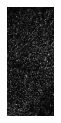

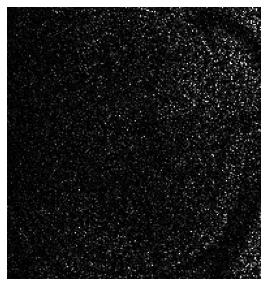

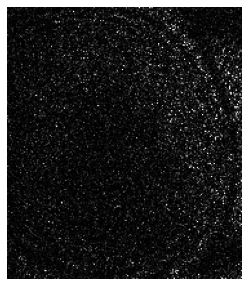

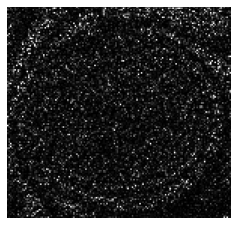

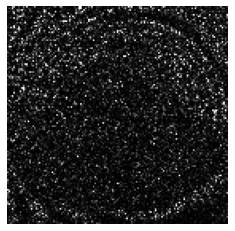

In [ ]:
def show_top_losses(res_df, preds, targs, losses, dls, n=5):
    for j in range(n):
        showpred(res_df.iloc[j]['i'], preds, targs, losses, dls)
        
show_top_losses(res_df, preds, targs, losses, dls)

So then we can these results output into a CSV file, and use it to direct our data-cleaning efforts, i.e. look at the top-loss images first! 

In [ ]:
res_df.to_csv('ring_count_top_losses_real.csv', index=False)